<div style="text-align: center"><h1 style="text-decoration: underline;">DSML Project</h1></div>



This is the official Notebook of the DSML Project from Marc Rennefort, Kilian Lipinsky, Timo Hagelberg, Jan Behrendt-Emden and Paul Severin. In order to create this Project we used the following dataset: https://data.cityofchicago.org/Transportation/Transportation-Network-Providers-Trips-2023-2024-/n26f-ihde/about_data
<h4 style="text-decoration: underline;">1. Description</h4>
The goal of this project is to predict ride-hailing tips in Chicago based on travel time, distance, fare amount, weather conditions, and whether the customer shared the ride.


In [1]:
#Note all your imports here

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from holoviews.plotting.plotly import ScatterPlot
from numpy.ma.core import inner
from pandas.core.common import random_state
from sklearn.preprocessing import StandardScaler
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LinearRegression
from datetime import datetime
from sklearn.model_selection import train_test_split
from meteostat import Hourly, Point


<h4 style="text-decoration: underline;">2. Data Prepertion</h4>

<h4 style="text-decoration: underline;">2.1 Some Basic Data Preperation</h4>
In the first step we want to do some basic data preperartion which means that we load our data set with the columns we need, we drop all rows with null values and changing our timestamps to datetime format

In [2]:
#Loading our dataset with the columns we need

data_cleaned = pd.read_csv('Data/Chicago_RideHailing_Data.csv', usecols= ['Trip ID', 'Trip Start Timestamp', 'Trip End Timestamp', 'Trip Seconds', 'Trip Miles', 'Fare', 'Tip', 'Trip Total','Dropoff Centroid Latitude', 'Dropoff Centroid Longitude', 'Shared Trip Authorized', 'Shared Trip Match'])

In [3]:
#Get some basic understanding of our data
print('Null Values: ', data_cleaned.isnull().sum())
data_cleaned.info()
data_cleaned.head()

Null Values:  Trip ID                             0
Trip Start Timestamp                0
Trip End Timestamp                  0
Trip Seconds                     1638
Trip Miles                          1
Fare                            68110
Tip                             68110
Trip Total                      68110
Shared Trip Authorized              1
Shared Trip Match                   1
Dropoff Centroid Latitude     2416867
Dropoff Centroid Longitude    2416867
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27423899 entries, 0 to 27423898
Data columns (total 12 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   Trip ID                     object 
 1   Trip Start Timestamp        object 
 2   Trip End Timestamp          object 
 3   Trip Seconds                float64
 4   Trip Miles                  float64
 5   Fare                        float64
 6   Tip                         float64
 7   Trip Total                  

,Trip ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Fare,Tip,Trip Total,Shared Trip Authorized,Shared Trip Match,Dropoff Centroid Latitude,Dropoff Centroid Longitude
0,8255c0b48b877bda14fbc2f490b6e42f359c44ec,09/19/2023 06:15:00 PM,09/19/2023 07:15:00 PM,3109.0,23.5,32.5,0.0,40.70,False,False,41.893216,-87.637844
1,8255c1529cdd828c3ce4e6bdc494c734e8432025,09/28/2023 12:15:00 PM,09/28/2023 12:45:00 PM,1640.0,14.7,30.0,0.0,38.74,False,False,41.979071,-87.903040
2,8255c247359d6e148930ba860afa3282848c67ed,09/03/2023 05:15:00 PM,09/03/2023 05:30:00 PM,772.0,1.9,20.0,0.0,22.39,False,False,41.879255,-87.642649
3,8255c37a57997b77f75da6af598a38fc28b4e832,09/13/2023 03:30:00 PM,09/13/2023 03:30:00 PM,452.0,1.1,10.0,0.0,14.07,False,False,41.892042,-87.631864
4,8255c6b273a32b3a76d7dad03328abb229de7fbd,09/16/2023 01:00:00 PM,09/16/2023 01:00:00 PM,819.0,3.9,10.0,0.0,12.89,False,False,41.792592,-87.769615


In [4]:
#Drop all rows with null values
data_cleaned = data_cleaned.dropna(axis = 0)

In [5]:
#Changing our timestamps to datetime format
data_cleaned['Trip Start Timestamp'] = pd.to_datetime(data_cleaned['Trip Start Timestamp'],  format='%m/%d/%Y %I:%M:%S %p', errors='coerce')
data_cleaned['Trip End Timestamp'] = pd.to_datetime(data_cleaned['Trip End Timestamp'],  format='%m/%d/%Y %I:%M:%S %p', errors='coerce')

In [6]:
#Check if everything worked correctly
print('Null-Werte: ', data_cleaned.isnull().sum())
data_cleaned.info()

Null-Werte:  Trip ID                       0
Trip Start Timestamp          0
Trip End Timestamp            0
Trip Seconds                  0
Trip Miles                    0
Fare                          0
Tip                           0
Trip Total                    0
Shared Trip Authorized        0
Shared Trip Match             0
Dropoff Centroid Latitude     0
Dropoff Centroid Longitude    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 24946147 entries, 0 to 27423897
Data columns (total 12 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   Trip ID                     object        
 1   Trip Start Timestamp        datetime64[ns]
 2   Trip End Timestamp          datetime64[ns]
 3   Trip Seconds                float64       
 4   Trip Miles                  float64       
 5   Fare                        float64       
 6   Tip                         float64       
 7   Trip Total                  float64       


<h4 style="text-decoration: underline;">2.2 Including weather data</h4>
In order to add the weather data we need to group our data because otherwise we will get runtime issues if we do API calls for barely 25 Million rows. This should be fine for our prediction purposes because there won't be huge differences in temperature or rain if we round by the second decimal place

In [7]:
#Round the Latitude and Longitude by the second decimal place and insert it in a new column
data_cleaned["Latitude rounded"] =  data_cleaned["Dropoff Centroid Latitude"].round(2)
data_cleaned["Longitude rounded"] = data_cleaned["Dropoff Centroid Longitude"].round(2)

#Group the data by Latitude and Longitude
data_grouped = data_cleaned.groupby(["Latitude rounded", "Longitude rounded"])["Trip End Timestamp"].agg(["min", "max"]).reset_index()
data_grouped.head()

,Latitude rounded,Longitude rounded,min,max
0,41.65,-87.60,2023-08-31 01:00:00,2024-04-28 23:30:00
1,41.65,-87.56,2023-08-31 12:45:00,2024-03-29 07:45:00
2,41.66,-87.65,2023-08-31 08:30:00,2024-03-30 21:30:00
3,41.66,-87.64,2023-08-31 02:00:00,2024-04-28 13:15:00
4,41.66,-87.60,2023-08-31 00:00:00,2024-04-26 08:30:00


In [8]:
weather_list = []
for i in range(len(data_grouped)):
    #Initalise variables
    latitude = data_grouped["Latitude rounded"].iloc[i]
    longitude = data_grouped["Longitude rounded"].iloc[i]
    location = Point(latitude, longitude)
    timestamp_min = data_grouped["min"].iloc[i]
    timestamp_max = data_grouped["max"].iloc[i]
    
    #Round min and max column to the next hour in order to extract the weather data correctly
    timestamp_min_rounded = timestamp_min.replace(minute = 0, second = 0) 
    timestamp_max_rounded = timestamp_max.replace(minute = 0, second = 0)
    
    #Extract the weather data per location
    weather = Hourly(location, timestamp_min_rounded, timestamp_max_rounded).fetch()

    #Merge the extracted weather data with the fitting timestamps and locations
    for j in range(len(weather)):
       weather_list.append({"Timestamp": weather.index[j], "Latitude rounded": latitude, "Longitude rounded": longitude, "Temperature": weather["temp"].iloc[j], "Rain in mm": weather["prcp"].iloc[j]})

#Covert the list to a DataFrame
weather_data = pd.DataFrame(weather_list)
weather_data.head()

,Timestamp,Latitude rounded,Longitude rounded,Temperature,Rain in mm
0,2023-08-31 01:00:00,41.65,-87.6,16.1,0.0
1,2023-08-31 02:00:00,41.65,-87.6,15.8,0.0
2,2023-08-31 03:00:00,41.65,-87.6,15.6,0.0
3,2023-08-31 04:00:00,41.65,-87.6,15.2,0.0
4,2023-08-31 05:00:00,41.65,-87.6,14.5,0.0


In [9]:
#Now we prepare the merge of the weather data and the other data. For this we need to round our timestamps by the next hour because our weather data is given hourly
data_cleaned["Trip End Timestamp Rounded"] = data_cleaned["Trip End Timestamp"].dt.floor("h")


In [10]:
#In the next step we can start with the merge
data_merged = pd.merge(data_cleaned, weather_data, left_on=["Trip End Timestamp Rounded", "Latitude rounded", "Longitude rounded"], right_on =["Timestamp", "Latitude rounded", "Longitude rounded"], how = "inner")

In [11]:
#After that we can drop all the columns we just needed to merge our data
data_merged = data_merged.drop(columns = ["Dropoff Centroid Latitude", "Dropoff Centroid Longitude", "Latitude rounded", "Longitude rounded", "Timestamp" ,"Trip Start Timestamp", "Trip End Timestamp", "Trip End Timestamp Rounded", "Trip End Timestamp Rounded", "Trip ID"])
data_merged.head()

,Trip Seconds,Trip Miles,Fare,Tip,Trip Total,Shared Trip Authorized,Shared Trip Match,Temperature,Rain in mm
0,3109.0,23.5,32.5,0.0,40.70,False,False,16.7,0.3
1,1640.0,14.7,30.0,0.0,38.74,False,False,18.9,0.0
2,772.0,1.9,20.0,0.0,22.39,False,False,31.1,0.0
3,452.0,1.1,10.0,0.0,14.07,False,False,17.8,0.0
4,819.0,3.9,10.0,0.0,12.89,False,False,16.1,0.0


<h4 style="text-decoration: underline;">2.3 Creation of dummy variables</h4>
To perform or regression later on we need to transfer the 'Shared Trip Authorized' and 'Shared Trip Match' column from boolean to numeric datatype. For this we make use of dummy variable where 1 stands for true and 0 stands for false. In addition we need to creat dummy variables for the rain because we are not interested in the amount of rain on a certain day rather we want to plot wheter it rained or not. 

In [12]:
#Create dummy variable for 'Shared Trip Authorized' and 'Shared Trip Match' (1 = True and 0 = False)
data_merged["Shared Trip Authorized"] = data_merged["Shared Trip Authorized"].astype(int)
data_merged["Shared Trip Match"] = data_merged["Shared Trip Match"].astype(int)
print("📋First 5 Rows:")
data_merged.head()


📋First 5 Rows:


,Trip Seconds,Trip Miles,Fare,Tip,Trip Total,Shared Trip Authorized,Shared Trip Match,Temperature,Rain in mm
0,3109.0,23.5,32.5,0.0,40.70,0,0,16.7,0.3
1,1640.0,14.7,30.0,0.0,38.74,0,0,18.9,0.0
2,772.0,1.9,20.0,0.0,22.39,0,0,31.1,0.0
3,452.0,1.1,10.0,0.0,14.07,0,0,17.8,0.0
4,819.0,3.9,10.0,0.0,12.89,0,0,16.1,0.0


In [13]:
#We see that the column 'Rain in mm' is from datatype object but we need a numeric datatype to perform the dummy creation on this column. That's why wee need to transform this column to the right datatype
data_merged['Rain in mm'] = pd.to_numeric(data_merged['Rain in mm'], errors='coerce')

In [14]:
#Create dummy variables for 'Rain in mm' (0 = there was no rain, 1 = there was rain)
rained = []
for i in range(len(data_merged)):
    if data_merged["Rain in mm"].iloc[i] > 0:
        rained.append("1")
    else:
        rained.append("0")
rained_df = pd.DataFrame(rained)
data_merged["Rained"] = rained_df
print("📋First 5 Rows:")
data_merged.head()

📋First 5 Rows:


,Trip Seconds,Trip Miles,Fare,Tip,Trip Total,Shared Trip Authorized,Shared Trip Match,Temperature,Rain in mm,Rained
0,3109.0,23.5,32.5,0.0,40.70,0,0,16.7,0.3,1
1,1640.0,14.7,30.0,0.0,38.74,0,0,18.9,0.0,0
2,772.0,1.9,20.0,0.0,22.39,0,0,31.1,0.0,0
3,452.0,1.1,10.0,0.0,14.07,0,0,17.8,0.0,0
4,819.0,3.9,10.0,0.0,12.89,0,0,16.1,0.0,0


In [15]:
#Now we need to cast the 'Rained' column to int datatype because it is from type object yet
data_merged["Rained"] = data_merged["Rained"].astype(int)


In [16]:
data_merged = data_merged.drop(columns = ["Rain in mm"])
print("📋First 5 Rows:")
data_merged.head()

📋First 5 Rows:


,Trip Seconds,Trip Miles,Fare,Tip,Trip Total,Shared Trip Authorized,Shared Trip Match,Temperature,Rained
0,3109.0,23.5,32.5,0.0,40.70,0,0,16.7,1
1,1640.0,14.7,30.0,0.0,38.74,0,0,18.9,0
2,772.0,1.9,20.0,0.0,22.39,0,0,31.1,0
3,452.0,1.1,10.0,0.0,14.07,0,0,17.8,0
4,819.0,3.9,10.0,0.0,12.89,0,0,16.1,0


<h4 style="text-decoration: underline;">2.4 Dealing with outliers</h4>
Machine Learning algorithms are highly influenced by outliers which lead to bad performance such as overfitting. That's why we have to deal with them. In the next step we want to delete all rows with values which are more than 3 standard deviations away from our mean value  

In [17]:
#We don't need to deal with outliers on the columns with dummy variables because there can't be outliers if we just have the values 0 or 1
data_merged_without_tip = data_merged.drop(columns = ["Tip", "Shared Trip Authorized", "Shared Trip Match", "Rained"])
for columns in data_merged_without_tip.columns:
    #Calculate mean and standard deviation of the current column
    mean = data_merged_without_tip[columns].mean()
    std = data_merged_without_tip[columns].std()
    
    #Calculate upper and lower limit
    upperlimit = mean + 3 * std
    lowerlimit = mean - 3 * std

    #Replace all outliers with null values so we can remove them later
    data_merged.loc[(data_merged[columns] > upperlimit) | (data_merged[columns] < lowerlimit), columns] = np.nan

#Remove all null values (delete all outliers)    
data_without_outliers = data_merged.dropna(axis = 0)
print(f"❌ Deleted {len(data_merged) - len(data_without_outliers)} outliers")


❌ Deleted 1251985 outliers


<h4 style="text-decoration: underline;">3. Data Modeling</h4>

First of all we need to split our data in train, test and validation data.

In [18]:
#Define x and y vectors
x = data_without_outliers.drop(columns = ["Tip"])
y = data_without_outliers["Tip"]

#Perform train test validation split
x_train_data, x_test_data, y_train_data, y_test_data = train_test_split(x, y, test_size = 0.3, random_state = 42)
x_val_data, x_test_data, y_val_data, y_test_data = train_test_split(x_test_data, y_test_data, test_size = 0.5, random_state = 42)
print("Datasplit:")
print(f"🏋️ Training: {len(x_train_data)} Samples ({len(x_train_data)/len(data_without_outliers)*100:.1f}%)")
print(f"🔬 Testing: {len(x_test_data)} Samples ({len(x_test_data)/len(data_without_outliers)*100:.1f}%)")
print(f"✅ Validation: {len(x_val_data)} Samples ({len(x_val_data)/len(data_without_outliers)*100:.1f}%)")

Datasplit:
🏋️ Training: 16585913 Samples (70.0%)
🔬 Testing: 3554125 Samples (15.0%)
✅ Validation: 3554124 Samples (15.0%)


Let's plot the data to get an first overview on our predictors.

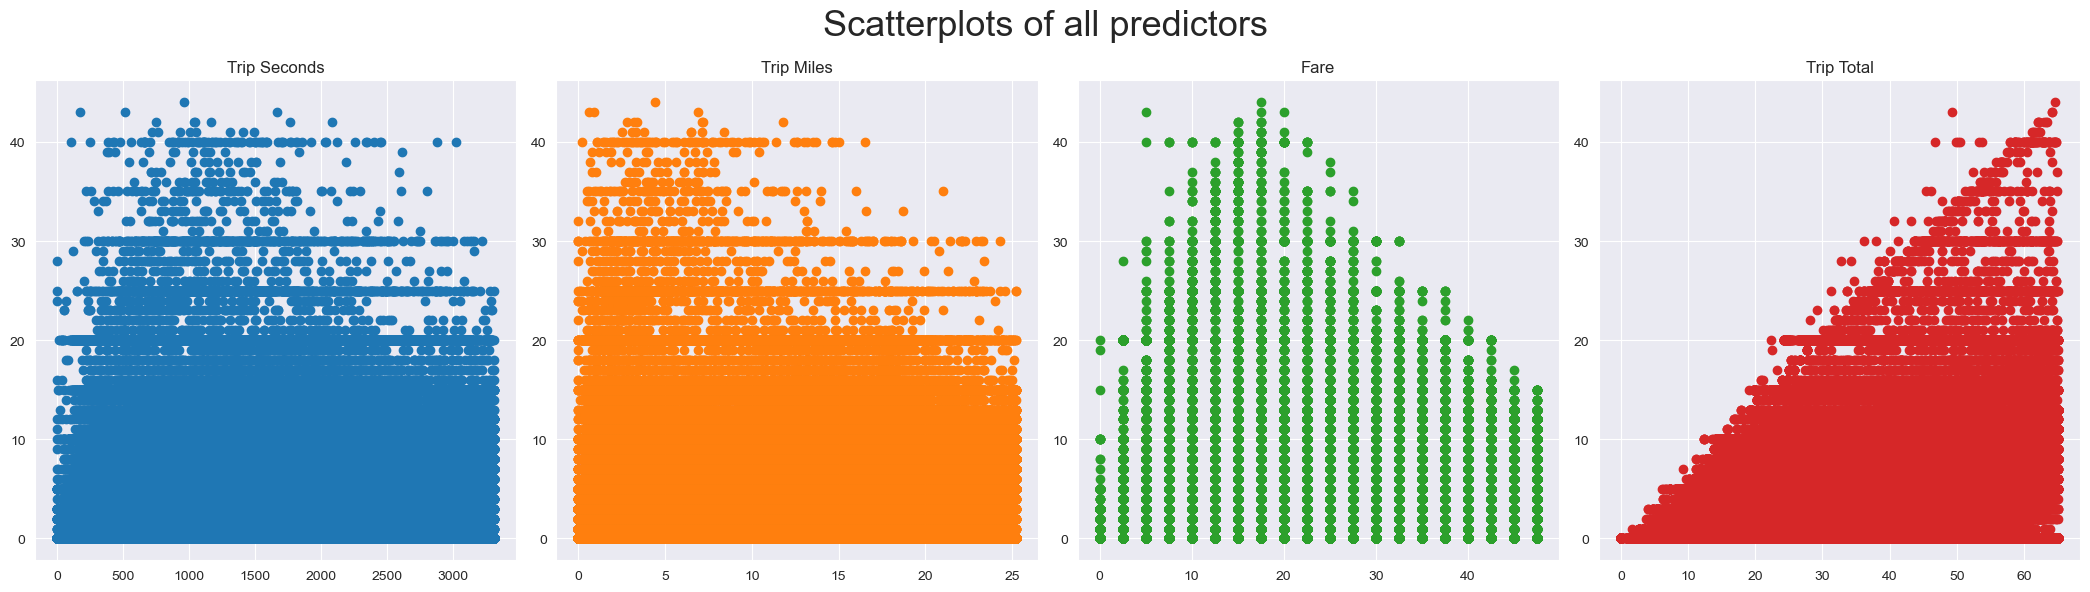

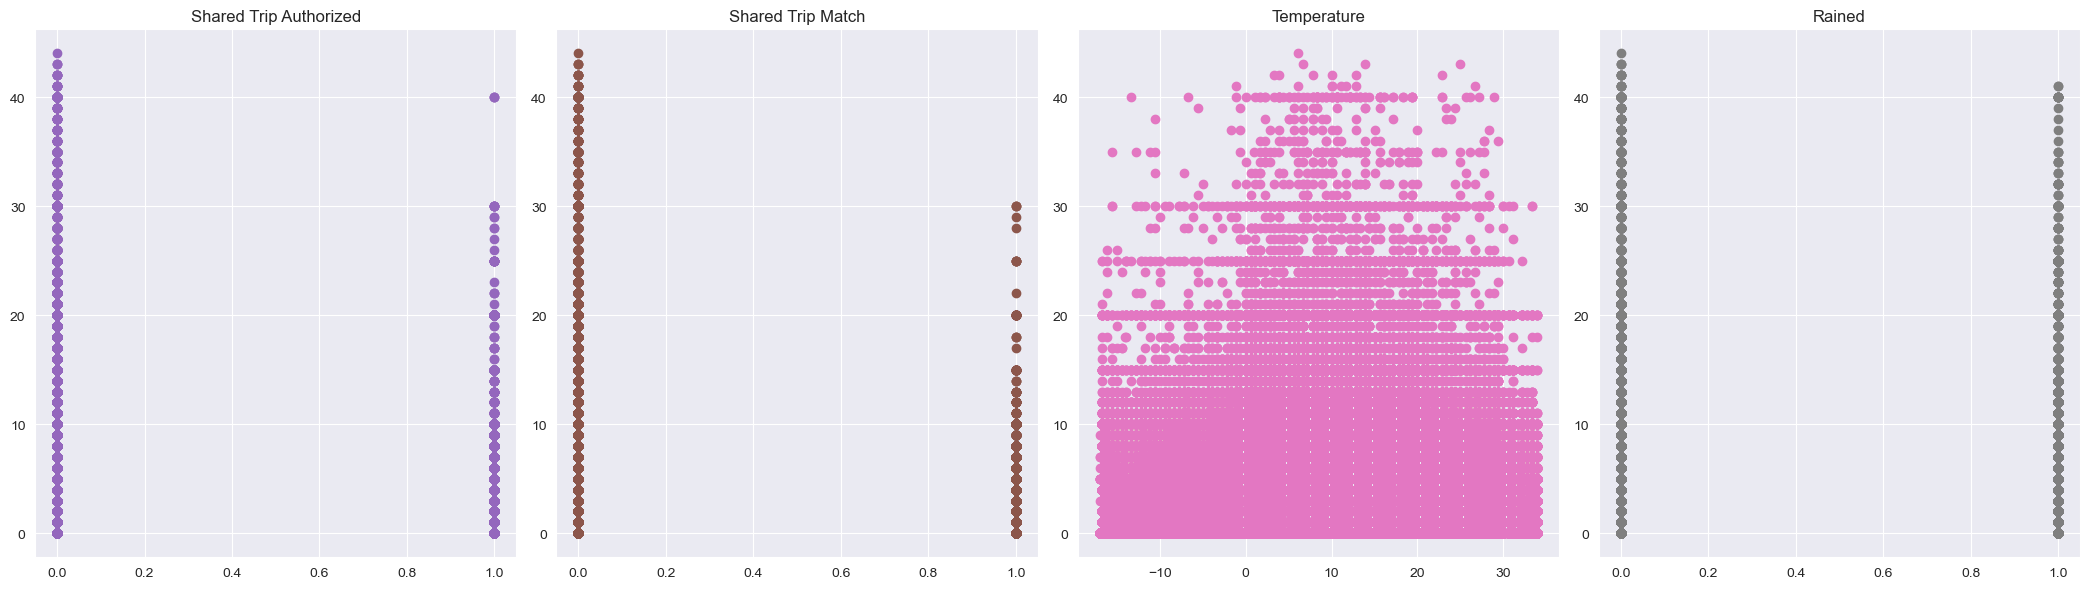

In [19]:
#Create Scatterplots for the first 4 predictors
fig_1, axes_1 = plt.subplots(nrows = 1, ncols = 4, figsize= (21,6))
fig_1.suptitle("Scatterplots of all predictors", fontsize=26)
for i, ax in enumerate(axes_1):
    ax.scatter(x = x_train_data.iloc[:, i], y = y_train_data, color = f'C{i}')
    ax.set_title(x_train_data.columns[i])
plt.tight_layout()
plt.show()

#Create Scatterplots for predictor 5-8
fig_2, axes_2 = plt.subplots(nrows = 1, ncols = 4, figsize= (21,6))
for i, ax in enumerate(axes_2):
    ax.scatter(x = x_train_data.iloc[:, i + 4], y = y_train_data, color = f'C{i + 4}')
    ax.set_title(x_train_data.columns[i + 4])
plt.tight_layout()
plt.show()

After plotting the data we get some interesting information. It looks like there are a lot of linear correlations for example between the trip total and the tip. Moreover it is noticeable that the predictors are on diffrent scales so we need to normalize them to get meaningful result in our regression later on.

In [20]:
#Normalize data
scaler = StandardScaler()
x_train_data_scaled = scaler.fit_transform(x_train_data)
#Hier nur noch transform verwenden, damit Mittelwert und Standardabweichung nicht neu berechnet werden
x_val_data_scaled = scaler.transform(x_val_data)
x_test_data_scaled = scaler.transform(x_test_data)